In [7]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Simulation parameters
# -----------------------------
resolution = 10  # pixels/um

# Materials
gaas = mp.Medium(epsilon=12)
air = mp.Medium(epsilon=1)

# Disk and waveguide geometry
disk_radius = 3.5
wg_length = 40
wg_width = 0.22
gap = 0.08  # distance between disk and waveguides

# Simulation cell size
cell_x = wg_length + 10
cell_y = 2*(disk_radius + gap + wg_width/2) + 10
cell = mp.Vector3(cell_x, cell_y, 0)

# PML layers
pml_layers = [mp.PML(2.0)]

# -----------------------------
# Geometry: disk + two waveguides
# -----------------------------
geometry = [
    mp.Cylinder(radius=disk_radius, height=mp.inf, center=mp.Vector3(0,0), material=gaas),
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, disk_radius + gap + wg_width/2),
             material=gaas),
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, -disk_radius - gap - wg_width/2),
             material=gaas)
]


# geometry_ref should contain the straight bus waveguide only (no disk)
geometry_ref = [
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, disk_radius + gap + wg_width/2, 0),
             material=gaas),
    # keep the lower waveguide too if you want identical background, but it doesn't create coupling
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, -disk_radius - gap - wg_width/2, 0),
             material=gaas)
]


-----------
Initializing structure...
time for choose_chunkdivision = 0.00393105 s
Working in 2D dimensions.
Computational cell is 50 x 17.4 x 0 with resolution 15
     block, center = (0,3.69,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.69,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.582751 s
-----------
on time step 856 (time=28.5333), 0.00467417 s/step
field decay(t = 50.03333333333333): 4.35513837941212e-11 / 4.35513837941212e-11 = 1.0
on time step 2327 (time=77.5667), 0.00272152 s/step
field decay(t = 100.06666666666666): 1.0408042527864906e-05 / 1.0408042527864906e-05 = 1.0
on time step 3828 (time=127.6), 0.00266505 s/step
field decay(t = 150.1): 5.169161527419081e-05 / 5.169161527419081e-05 = 1.0
field decay(t = 200.13333333333333): 1.055769925969035e

field decay(t = 600.4): 3.0335949656013414e-08 / 5.169161527419081e-05 = 0.0005868640299805044
run 0 finished at t = 600.4 (18012 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000484943 s
Working in 2D dimensions.
Computational cell is 50 x 17.4 x 0 with resolution 15
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.69,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.69,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.534405 s
-----------
on time step 1479 (time=49.3), 0.00270664 s/step
field decay(t = 50.03333333333333): 9.655531233210443e-13 / 9.655531233210443e-13 = 1.0
field decay(t = 100.06666666666666): 1.

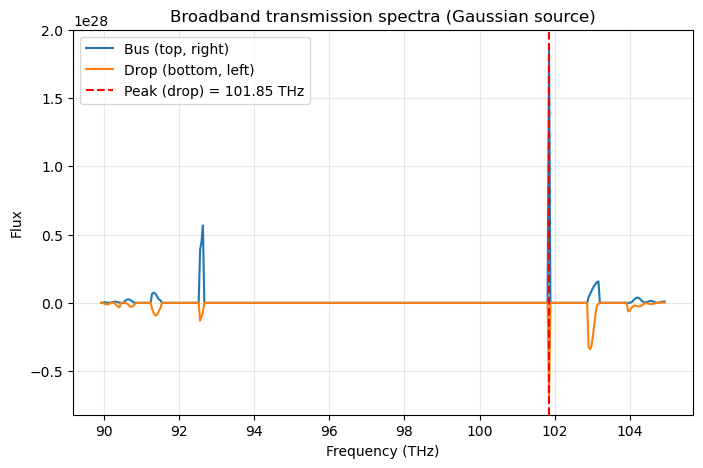

In [8]:


# -----------------------------
# Source (broadband run)
# -----------------------------
source_x = -wg_length/2
source_y = disk_radius + gap + wg_width/2

fmin = 0.3
fmax = 0.35
df = fmax - fmin
nfreq = 400
resolution = 15  # pixels/um

sources = [mp.Source(mp.GaussianSource(frequency=(fmin+fmax)/2, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, wg_width, 0))]

# -----------------------------
# Flux monitors
# -----------------------------
flux_region_bus = mp.FluxRegion(center=mp.Vector3(wg_length/2 - 1,
                                                  disk_radius + gap + wg_width/2),
                                size=mp.Vector3(0, wg_width, 0))

# Drop port moved to left side of lower waveguide (same side as source, opposite waveguide)
flux_region_drop = mp.FluxRegion(center=mp.Vector3(-wg_length/2 + 1,
                                                   -disk_radius - gap - wg_width/2),
                                 size=mp.Vector3(0, wg_width, 0))

# -----------------------------
# Reference simulation (no disk)
# -----------------------------

# place an input monitor just to the right of the source (measures launched guided power)
in_flux_region = mp.FluxRegion(center=mp.Vector3(source_x + 1.0, source_y, 0),
                               size=mp.Vector3(0, wg_width*2.0, 0))

sim_ref = mp.Simulation(cell_size=cell,
                        geometry=geometry_ref,
                        sources=sources,            # same source definition as device
                        boundary_layers=pml_layers,
                        resolution=resolution,
                        dimensions=3)

in_ref_flux = sim_ref.add_flux((fmin+fmax)/2, df, nfreq, in_flux_region)

# run the reference simulation (same stopping criteria you use for device)
sim_ref.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(), 5e-3))

# extract incident (reference) spectrum
freqs = np.array(mp.get_flux_freqs(in_ref_flux))
in_ref = np.array(mp.get_fluxes(in_ref_flux))



# -----------------------------
# First Simulation (spectra)
# -----------------------------
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution)

trans_flux_bus = sim.add_flux((fmin+fmax)/2, df, nfreq, flux_region_bus)
trans_flux_drop = sim.add_flux((fmin+fmax)/2, df, nfreq, flux_region_drop)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(), 5e-3))

frequencies = np.array(mp.get_flux_freqs(trans_flux_bus))
flux_bus = np.array(mp.get_fluxes(trans_flux_bus))
flux_drop = np.array(mp.get_fluxes(trans_flux_drop))

# --- Normalize by incident launched power ---
eps = 1e-30
in_ref_safe = np.maximum(in_ref, eps)
bus_norm = flux_bus / in_ref_safe
drop_norm = flux_drop / in_ref_safe

# -----------------------------
# Find resonance from max |flux_drop|
# -----------------------------
res_freq = frequencies[np.argmax(np.abs(drop_norm))]
print(f"Resonance frequency (max |drop port|): {res_freq:.6f} 1/um")

## Conversion: Meep freq (1/um) → THz
c0 = 299792458  # m/s
um_scale = 1e-6  # 1 µm in m
freq_thz = frequencies * c0 / um_scale / 1e12
res_freq_thz = res_freq * c0 / um_scale / 1e12

# Plot
plt.figure(figsize=(8,5))
plt.plot(freq_thz, bus_norm, label='Bus (top, right)')
plt.plot(freq_thz, drop_norm, label='Drop (bottom, left)')
plt.axvline(res_freq_thz, color='r', ls='--', label=f'Peak (drop) = {res_freq_thz:.2f} THz')
plt.xlabel('Frequency (THz)')
plt.ylabel('Flux')
plt.title('Broadband transmission spectra (Gaussian source)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

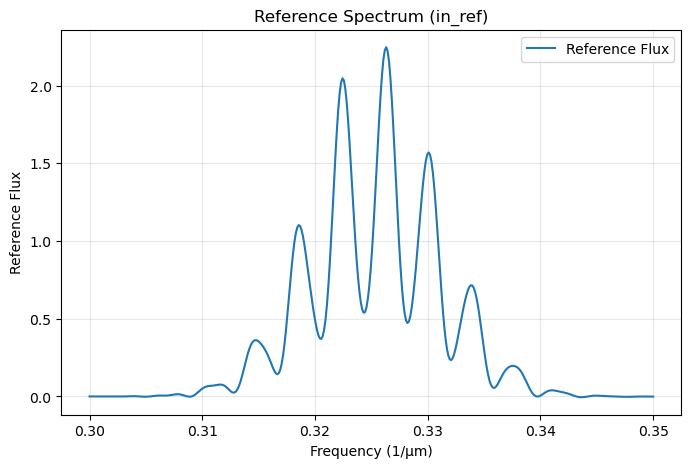

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(freqs, in_ref, label='Reference Flux')
plt.xlabel('Frequency (1/µm)')
plt.ylabel('Reference Flux')
plt.title('Reference Spectrum (in_ref)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000526905 s
Working in 2D dimensions.
Computational cell is 50 x 17.4 x 0 with resolution 15
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.69,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.69,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.585707 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 47.333333333333336/1000.0 = 4.7% done in 4.0s, 80.5s to go
on time step 1423 (time=47.4333), 0.00281363 s/step
Meep progress: 102.16666666666667/1000.0 = 10.2% done in 8.0s, 70.3s to go
on time step 3072 (time=102.4), 0.00242722 s/step
Meep progress: 152.96666666666667/1000.0 = 15.3% done in 12.0s, 66.5s to go
on time step 4597 (time=153.233), 0.0026236 s/step
Meep progress: 207.29999999999998/1000.0 = 20.7% done in 16.0s, 61.2s to go
on time step 6227 (time=207.567), 0.00245489 s/step
Meep progress: 265.26666666666665/1000.0 = 26.5% done in 20.0s, 55.4s to go
on time step 7966 (time=265.533), 0.00230214 s/step
Meep progress: 324.1666666666667/1000.0 = 32.4% done in 24.0s, 50.0s to go
on time step 9733 (time=324.433), 0.00226451 s/step
Meep progress: 377.3/1000.0 = 37.7% done in 28.0s, 46.2s to go
on time step 11326 (time=377.533), 0.00251187 s/step
Meep progress: 425.26666666666665/1000.0 = 42.5% done in 32.0s, 43.3s to go
on time step 12766 (time=425.533), 0.00278022 s

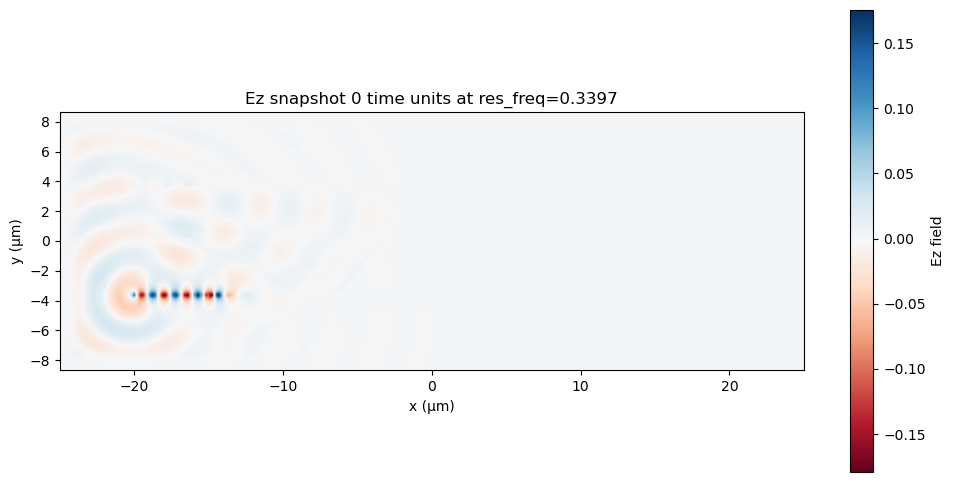

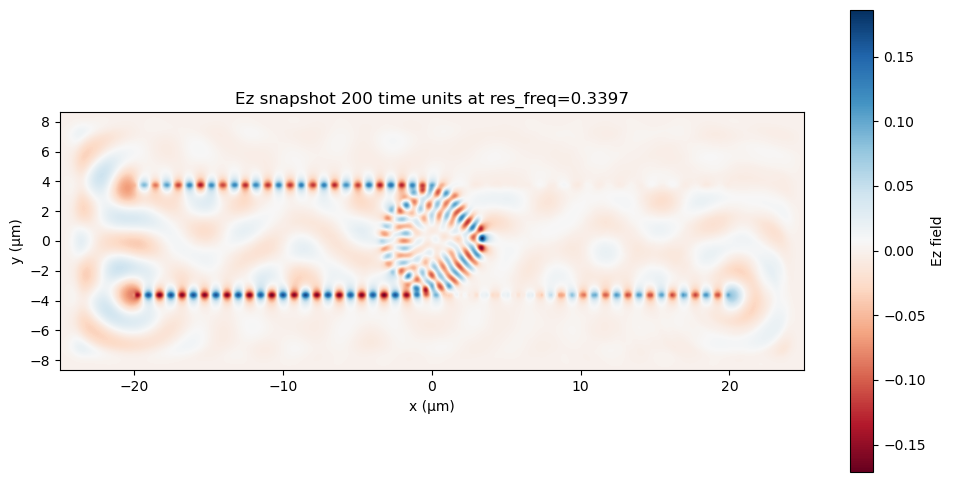

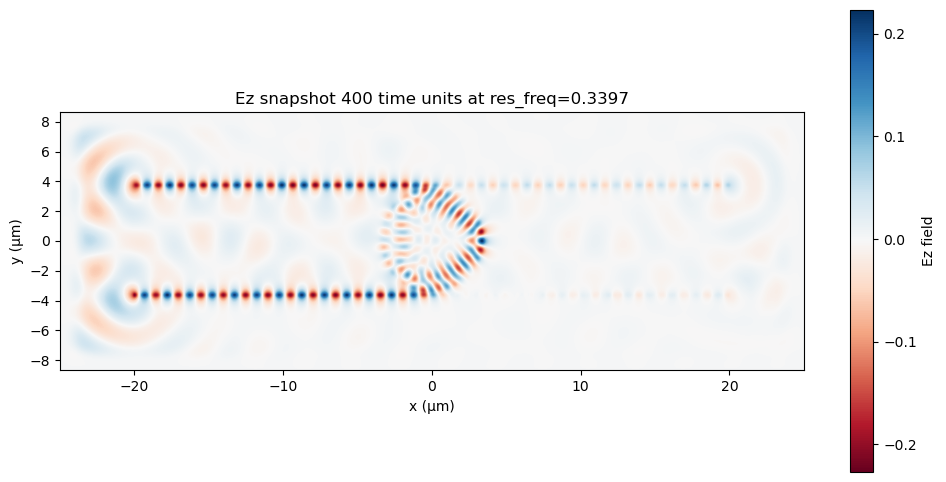

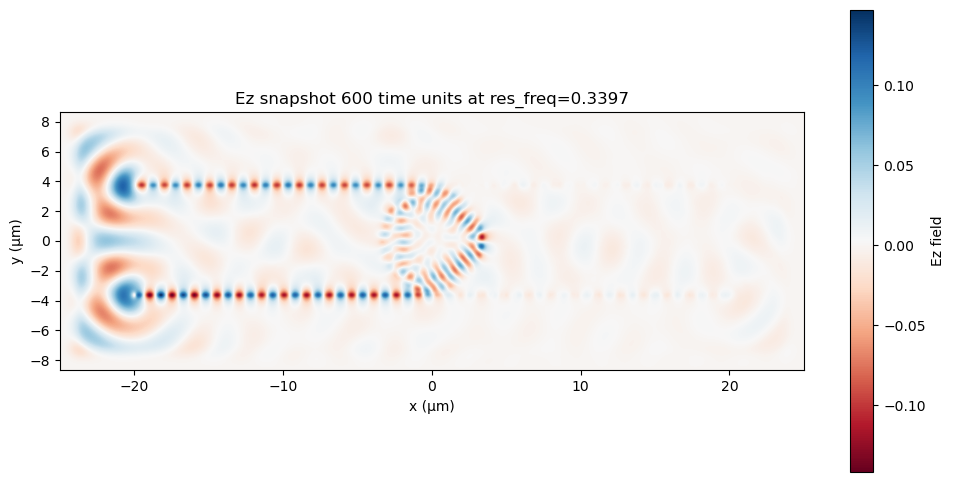

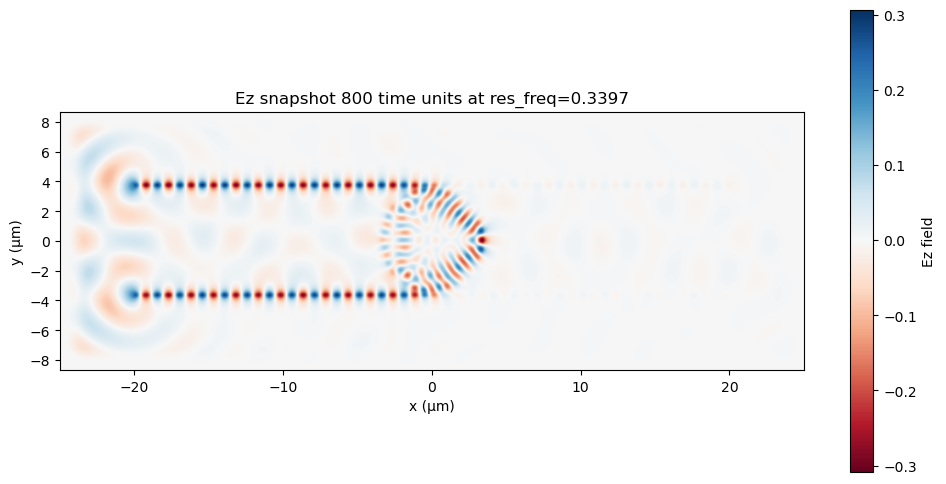

In [10]:
# -----------------------------
# Second Simulation (single freq)
# -----------------------------
sources_res = [mp.Source(mp.ContinuousSource(frequency=0.314),
                         component=mp.Ez,
                         center=mp.Vector3(source_x, source_y),
                         size=mp.Vector3(0, wg_width, 0))]

sim_res = mp.Simulation(cell_size=cell,
                        geometry=geometry,
                        sources=sources_res,
                        boundary_layers=pml_layers,
                        resolution=resolution)

ez_data = []
def store_fields(sim):
    ez_data.append(sim.get_array(center=mp.Vector3(),
                                 size=cell,
                                 component=mp.Ez))

sim_res.run(mp.at_every(20, store_fields), until=1000)

# -----------------------------
# Plot Ez snapshots
# -----------------------------
for i, field in enumerate(ez_data):
    if i % 10 == 0:
        plt.figure(figsize=(12,6))
        plt.imshow(np.rot90(field), cmap="RdBu", origin="lower",
                   extent=[-cell_x/2, cell_x/2, -cell_y/2, cell_y/2])
        plt.colorbar(label="Ez field")
        plt.title(f"Ez snapshot {i*20} time units at res_freq={res_freq:.4f}")
        plt.xlabel("x (µm)")
        plt.ylabel("y (µm)")
        plt.show()

In [14]:
import numpy as np


# --- Constants ---
c0 = 299_792_458         # speed of light in m/s
um_to_m = 1e-6           # conversion from micrometer to meter


# --- Optional: single frequency ---
f_meep = 0.645
f_thz = f_meep * c0 / um_to_m / 1e12
print(f"Meep freq {f_meep} -> {f_thz:.2f} THz")


# Freq to meep freq

f_thz =189.2

def thz_to_meep_freq(f_thz):
    """Convert frequency in THz to Meep frequency in 1/um."""
    f_meep = f_thz * 1e12 * um_to_m / c0
    return f_meep   

print(f" {thz_to_meep_freq(f_thz):.6f} 1/um")


Meep freq 0.645 -> 193.37 THz
 0.631103 1/um


-----------
Initializing structure...
time for choose_chunkdivision = 0.000798941 s
Working in 2D dimensions.
Computational cell is 50 x 17.4 x 0 with resolution 20
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.69,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.69,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


time for set_epsilon = 0.734968 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

Meep progress: 18.8/200.0 = 9.4% done in 4.0s, 38.6s to go
on time step 754 (time=18.85), 0.0053107 s/step
Meep progress: 39.0/200.0 = 19.5% done in 8.0s, 33.0s to go
on time step 1562 (time=39.05), 0.00495145 s/step
Meep progress: 59.725/200.0 = 29.9% done in 12.0s, 28.2s to go
on time step 2391 (time=59.775), 0.00483145 s/step
Meep progress: 82.17500000000001/200.0 = 41.1% done in 16.0s, 23.0s to go
on time step 3290 (time=82.25), 0.00444966 s/step
Meep progress: 105.42500000000001/200.0 = 52.7% done in 20.0s, 18.0s to go
on time step 4220 (time=105.5), 0.00430372 s/step
Meep progress: 128.875/200.0 = 64.4% done in 24.0s, 13.3s to go
on time step 5158 (time=128.95), 0.00426726 s/step
Meep progress: 151.20000000000002/200.0 = 75.6% done in 28.0s, 9.0s to go
on time step 6052 (time=151.3), 0.00448007 s/step
Meep progress: 172.20000000000002/200.0 = 86.1% done in 32.0s, 5.2s to go
on time step 6894 (time=172.35), 0.00475719 s/step
Meep progress: 194.925/200.0 = 97.5% done in 36.0s, 0.9s

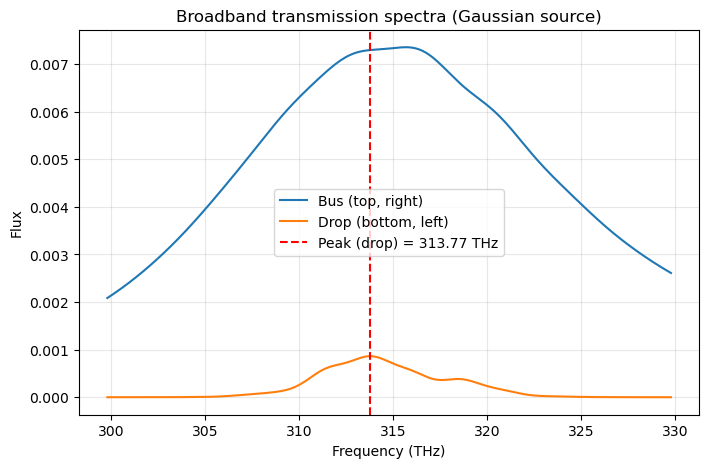

-----------
Initializing structure...
time for choose_chunkdivision = 0.000613928 s
Working in 2D dimensions.
Computational cell is 50 x 17.4 x 0 with resolution 20
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.69,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.69,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.548356 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

Meep progress: 20.150000000000002/200.0 = 10.1% done in 4.0s, 35.7s to go
on time step 806 (time=20.15), 0.00496307 s/step
Meep progress: 42.725/200.0 = 21.4% done in 8.0s, 29.5s to go
on time step 1709 (time=42.725), 0.00443029 s/step
Meep progress: 64.25/200.0 = 32.1% done in 12.0s, 25.4s to go
on time step 2570 (time=64.25), 0.0046464 s/step
Meep progress: 85.7/200.0 = 42.9% done in 16.0s, 21.3s to go
on time step 3428 (time=85.7), 0.00466228 s/step
Meep progress: 106.025/200.0 = 53.0% done in 20.0s, 17.7s to go
on time step 4242 (time=106.05), 0.00491765 s/step
Meep progress: 129.125/200.0 = 64.6% done in 24.0s, 13.2s to go
on time step 5166 (time=129.15), 0.00433095 s/step
Meep progress: 152.32500000000002/200.0 = 76.2% done in 28.0s, 8.8s to go
on time step 6094 (time=152.35), 0.00431086 s/step
Meep progress: 173.45000000000002/200.0 = 86.7% done in 32.0s, 4.9s to go
on time step 6939 (time=173.475), 0.00473778 s/step
Meep progress: 194.45000000000002/200.0 = 97.2% done in 36.0s,

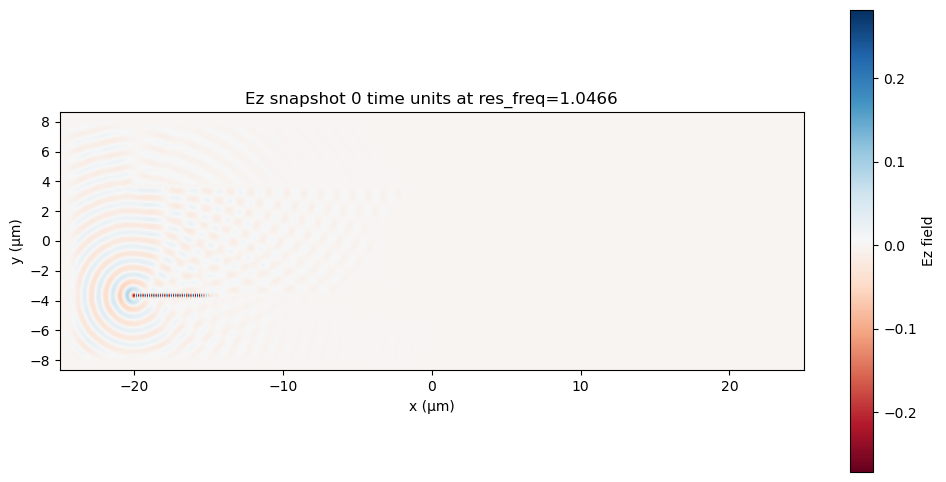

In [18]:

# -----------------------------
# Source (broadband run)
# -----------------------------
source_x = -wg_length/2
source_y = disk_radius + gap + wg_width/2

fmin = 1
fmax = 1.1
df = fmax - fmin
nfreq = 400
resolution = 20  # pixels/um

sources = [mp.Source(mp.GaussianSource(frequency=(fmin+fmax)/2, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, wg_width, 0))]

# -----------------------------
# Flux monitors
# -----------------------------
flux_region_bus = mp.FluxRegion(center=mp.Vector3(wg_length/2 - 1,
                                                  disk_radius + gap + wg_width/2),
                                size=mp.Vector3(0, wg_width, 0))

# Drop port moved to left side of lower waveguide (same side as source, opposite waveguide)
flux_region_drop = mp.FluxRegion(center=mp.Vector3(-wg_length/2 + 1,
                                                   -disk_radius - gap - wg_width/2),
                                 size=mp.Vector3(0, wg_width, 0))

# -----------------------------
# First Simulation (spectra)
# -----------------------------
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution)

trans_flux_bus = sim.add_flux((fmin+fmax)/2, df, nfreq, flux_region_bus)
trans_flux_drop = sim.add_flux((fmin+fmax)/2, df, nfreq, flux_region_drop)

#sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(), 1e-2))
sim.run(until=200)

frequencies = np.array(mp.get_flux_freqs(trans_flux_bus))
flux_bus = np.array(mp.get_fluxes(trans_flux_bus))
flux_drop = np.array(mp.get_fluxes(trans_flux_drop))

# -----------------------------
# Find resonance from max |flux_drop|
# -----------------------------
res_freq = frequencies[np.argmax(np.abs(flux_drop))]
print(f"Resonance frequency (max |drop port|): {res_freq:.6f} 1/um")

## Conversion: Meep freq (1/um) → THz
c0 = 299792458  # m/s
um_scale = 1e-6  # 1 µm in m
freq_thz = frequencies * c0 / um_scale / 1e12
res_freq_thz = res_freq * c0 / um_scale / 1e12

# Plot
plt.figure(figsize=(8,5))
plt.plot(freq_thz, flux_bus, label='Bus (top, right)')
plt.plot(freq_thz, flux_drop, label='Drop (bottom, left)')
plt.axvline(res_freq_thz, color='r', ls='--', label=f'Peak (drop) = {res_freq_thz:.2f} THz')
plt.xlabel('Frequency (THz)')
plt.ylabel('Flux')
plt.title('Broadband transmission spectra (Gaussian source)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# -----------------------------
# Second Simulation (single freq)
# -----------------------------
sources_res = [mp.Source(mp.ContinuousSource(frequency=res_freq),
                         component=mp.Ez,
                         center=mp.Vector3(source_x, source_y),
                         size=mp.Vector3(0, wg_width, 0))]

sim_res = mp.Simulation(cell_size=cell,
                        geometry=geometry,
                        sources=sources_res,
                        boundary_layers=pml_layers,
                        resolution=resolution)

ez_data = []
def store_fields(sim):
    ez_data.append(sim.get_array(center=mp.Vector3(),
                                 size=cell,
                                 component=mp.Ez))

sim_res.run(mp.at_every(20, store_fields), until=200)

# -----------------------------
# Plot Ez snapshots
# -----------------------------
for i, field in enumerate(ez_data):
    if i % 10 == 0:
        plt.figure(figsize=(12,6))
        plt.imshow(np.rot90(field), cmap="RdBu", origin="lower",
                   extent=[-cell_x/2, cell_x/2, -cell_y/2, cell_y/2])
        plt.colorbar(label="Ez field")
        plt.title(f"Ez snapshot {i*20} time units at res_freq={res_freq:.4f}")
        plt.xlabel("x (µm)")
        plt.ylabel("y (µm)")
        plt.show()

     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.95,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.95,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


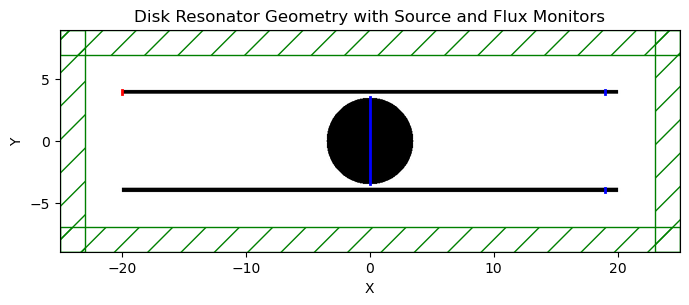

In [4]:
import meep as mp
import matplotlib.pyplot as plt

# -----------------------------
# Simulation parameters
# -----------------------------
resolution = 20  # pixels/um

gaas = mp.Medium(epsilon=12)
air = mp.Medium(epsilon=1)

disk_radius = 3.5
wg_length = 40
wg_width = 0.3
gap = 0.3

cell_x = wg_length + 10
cell_y = 2*(disk_radius + gap + wg_width/2) + 10
cell = mp.Vector3(cell_x, cell_y, 0)

pml_layers = [mp.PML(2.0)]

# -----------------------------
# Geometry
# -----------------------------
geometry = [
    mp.Cylinder(radius=disk_radius, height=mp.inf, center=mp.Vector3(0,0), material=gaas),
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, disk_radius + gap + wg_width/2),
             material=gaas),   # bus waveguide
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, -disk_radius - gap - wg_width/2),
             material=gaas)   # drop waveguide
]

# -----------------------------
# Source
# -----------------------------
source_x = -wg_length/2
source_y = disk_radius + gap + wg_width/2

fmin = 0.1
fmax = 0.2
df = fmax - fmin

sources = [mp.Source(mp.GaussianSource(frequency=(fmin+fmax)/2, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, wg_width, 0))]

# -----------------------------
# Flux Monitors
# -----------------------------
flux_region_disk = mp.FluxRegion(center=mp.Vector3(0,0), size=mp.Vector3(0, 2*disk_radius, 0))
flux_region_bus  = mp.FluxRegion(center=mp.Vector3(wg_length/2 - 1, disk_radius + gap + wg_width/2),
                                 size=mp.Vector3(0, wg_width, 0))
flux_region_drop = mp.FluxRegion(center=mp.Vector3(wg_length/2 - 1, -disk_radius - gap - wg_width/2),
                                 size=mp.Vector3(0, wg_width, 0))

# -----------------------------
# Simulation (just for plotting)
# -----------------------------
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution)

# Add flux objects (so they show up in the plot)
sim.add_flux((fmin+fmax)/2, df, 100, flux_region_disk)
sim.add_flux((fmin+fmax)/2, df, 100, flux_region_bus)
sim.add_flux((fmin+fmax)/2, df, 100, flux_region_drop)

# -----------------------------
# Plot geometry + sources + flux monitors
# -----------------------------
fig, ax = plt.subplots(figsize=(8,6))
sim.plot2D(ax=ax, output_plane=mp.Volume(center=mp.Vector3(), size=cell))
plt.title("Disk Resonator Geometry with Source and Flux Monitors")
plt.show()



-----------
Initializing structure...
time for choose_chunkdivision = 0.000558138 s
Working in 2D dimensions.
Computational cell is 50 x 17.8 x 0 with resolution 25
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.75,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)


          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.75,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 1.04879 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1425.0)

Meep progress: 8.78/1425.0 = 0.6% done in 4.0s, 645.8s to go
on time step 440 (time=8.8), 0.00910168 s/step
Meep progress: 17.84/1425.0 = 1.3% done in 8.0s, 631.9s to go
on time step 893 (time=17.86), 0.00884921 s/step
Meep progress: 30.66/1425.0 = 2.2% done in 12.0s, 546.6s to go
on time step 1534 (time=30.68), 0.00624623 s/step
Meep progress: 40.04/1425.0 = 2.8% done in 16.0s, 554.2s to go
on time step 2003 (time=40.06), 0.00853169 s/step
Meep progress: 49.5/1425.0 = 3.5% done in 20.0s, 556.4s to go
on time step 2476 (time=49.52), 0.00846105 s/step
Meep progress: 59.08/1425.0 = 4.1% done in 24.0s, 555.5s to go
on time step 2955 (time=59.1), 0.0083545 s/step
Meep progress: 68.2/1425.0 = 4.8% done in 28.0s, 557.6s to go
on time step 3411 (time=68.22), 0.00877906 s/step
Meep progress: 77.18/1425.0 = 5.4% done in 32.0s, 559.4s to go
on time step 3860 (time=77.2), 0.00891378 s/step
Meep progress: 86.68/1425.0 = 6.1% done in 36.0s, 556.4s to go
on time step 4335 (time=86.7), 0.00842793 s/s

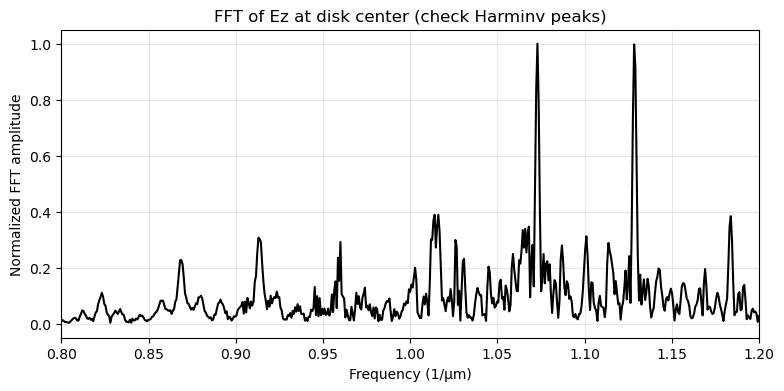

Resonance frequency (from FFT peak): 1.073003 1/µm
-----------
Initializing structure...
time for choose_chunkdivision = 0.000664949 s
Working in 2D dimensions.
Computational cell is 50 x 17.8 x 0 with resolution 25
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.75,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.75,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = -0.263071 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

Meep progress: 5.22/200.0 = 2.6% done in 4.0s, 149.4s to go
on time step 262 (time=5.24), 0.0153175 s/step
Meep progress: 9.3/200.0 = 4.7% done in 8.0s, 164.3s to go
on time step 467 (time=9.34), 0.0195724 s/step
Meep progress: 16.82/200.0 = 8.4% done in 12.0s, 130.9s to go
on time step 843 (time=16.86), 0.0106565 s/step
Meep progress: 24.72/200.0 = 12.4% done in 16.0s, 113.6s to go
on time step 1238 (time=24.76), 0.010147 s/step
Meep progress: 32.38/200.0 = 16.2% done in 20.0s, 103.7s to go
on time step 1620 (time=32.4), 0.0105185 s/step
Meep progress: 40.18/200.0 = 20.1% done in 24.0s, 95.6s to go
on time step 2012 (time=40.24), 0.0102151 s/step
Meep progress: 47.88/200.0 = 23.9% done in 28.1s, 89.1s to go
on time step 2397 (time=47.94), 0.0104056 s/step
Meep progress: 58.96/200.0 = 29.5% done in 32.1s, 76.7s to go
on time step 2951 (time=59.02), 0.00724971 s/step
Meep progress: 64.5/200.0 = 32.2% done in 36.1s, 75.8s to go
on time step 3230 (time=64.6), 0.0143695 s/step
Meep progres

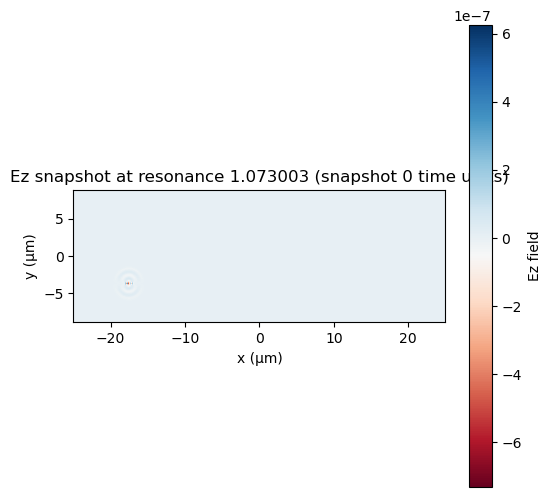

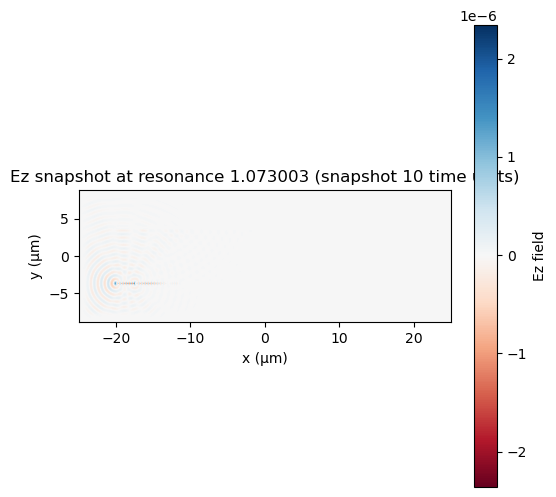

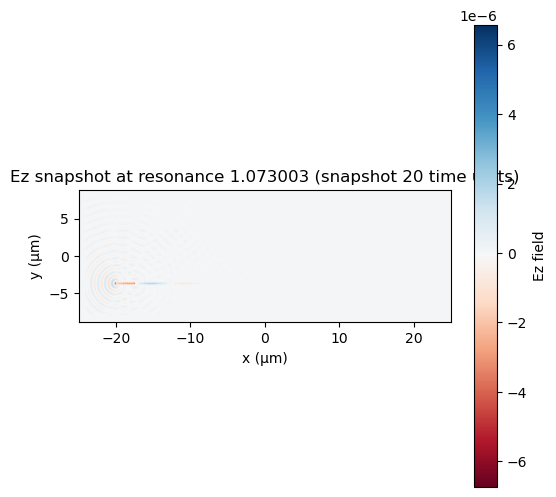

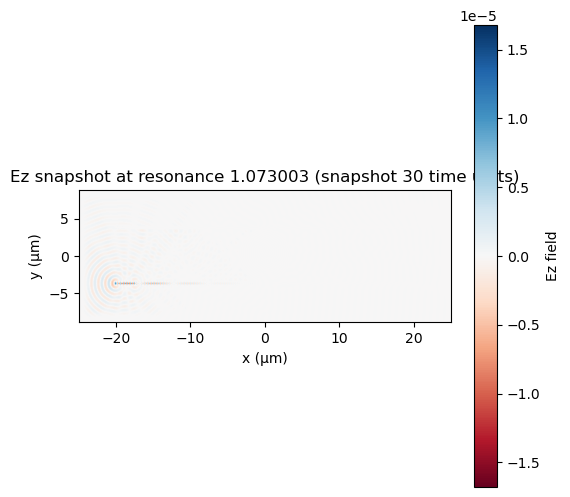

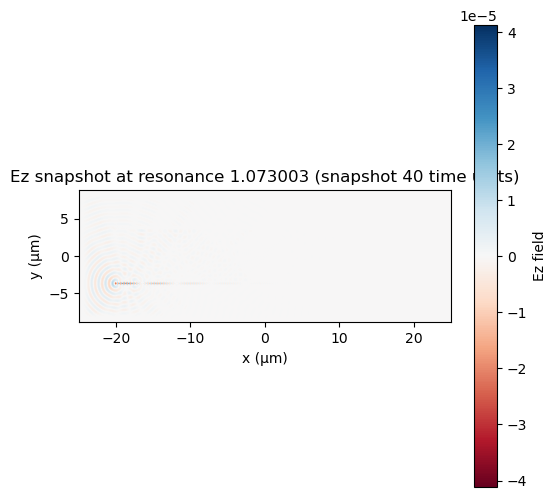

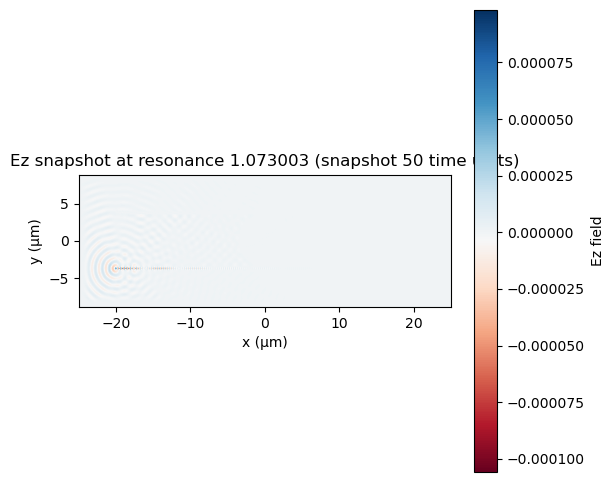

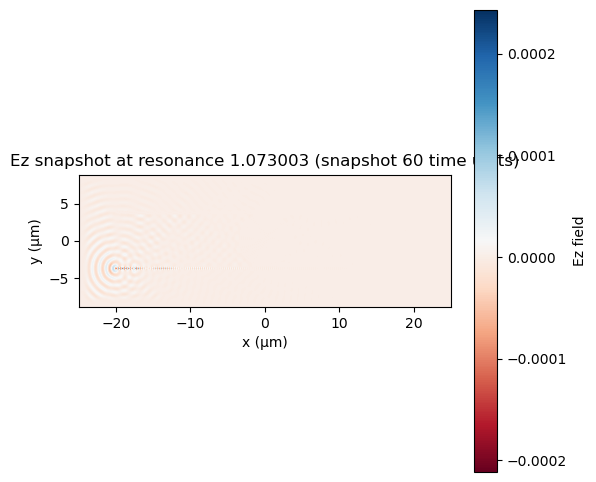

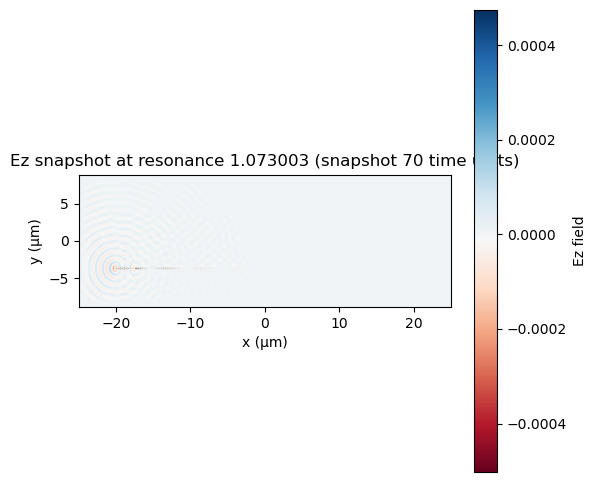

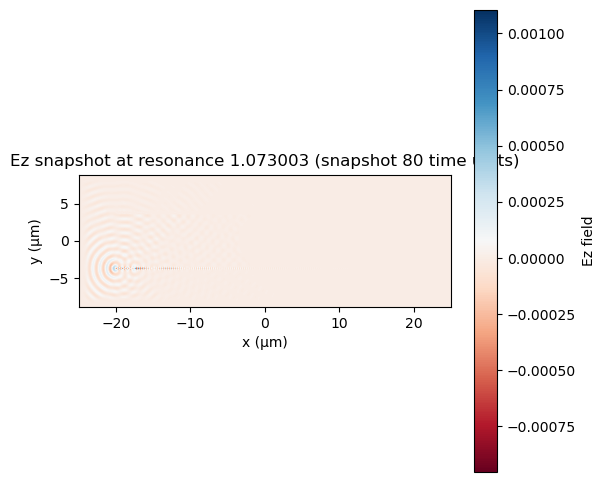

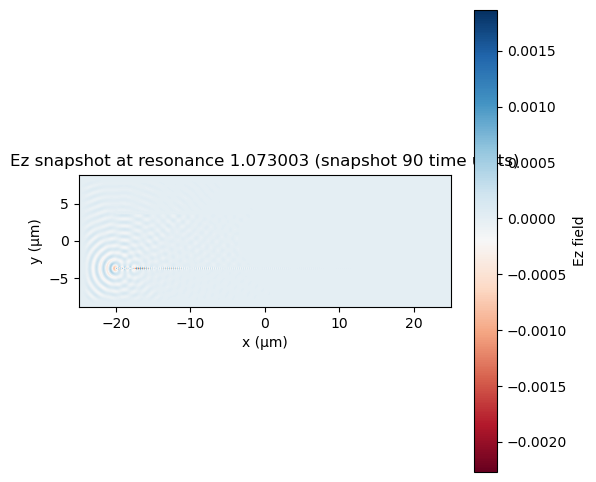

In [53]:
# -----------------------------
# Recommended: Harminv + well-sampled FFT
# -----------------------------
# (Replace your sim creation / sim.run lines with this block)

# 1) stronger resolution and more focused band (tune these values)
resolution = 25                     # increase spatial resolution (px / µm)
fcen = 1                        # center frequency to search (1/um) — adjust to expected band
fband = 0.2                         # total bandwidth around fcen to search (1/um)
fmin = fcen - fband/2
fmax = fcen + fband/2
nfreq = 800                        # if you still use DFT monitors

# Rebuild sim with higher resolution
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution,
                    dimensions=2)

# Harminv parameters
harminv_center = fcen
harminv_band = fband

# Monitor point inside the disk (pick a point with expected strong field)
monitor_pt = mp.Vector3(disk_radius-0.2, 0)

# set longer "listen" time for high-Q modes
run_time_after_sources = 1400.0   # increase until peaks are sharp; may need 1000-2000 for very high Q

# 2) record a high-rate time signal at the monitor point for FFT
dt_sample = 0.05   # time sampling interval (choose <= 1/(2*max_expected_freq)); e.g. 0.05 is safe for f~1.0
time_signal = []
time_stamps = []

def store_signal(sim):
    time_signal.append(sim.get_field_point(mp.Ez, monitor_pt))
    time_stamps.append(sim.meep_time())

# Create Harminv analyser (will run after sources)
harminv = mp.Harminv(mp.Ez, monitor_pt, harminv_center, harminv_band)

# Run: both sampling and Harminv
sim.run(mp.at_every(dt_sample, store_signal), mp.after_sources(harminv),
        until_after_sources=run_time_after_sources)

# 3) FFT of recorded signal (properly sampled, windowed)
time_signal = np.array(time_signal)
time_stamps = np.array(time_stamps)
N = len(time_signal)
if N < 8:
    raise RuntimeError("Too few samples recorded — reduce dt_sample or increase total runtime.")

dt = np.mean(np.diff(time_stamps))
# window the signal to reduce leakage
window = np.hanning(N)
sig = time_signal * window

S = np.fft.fft(sig)
freqs = np.fft.fftfreq(N, d=dt)   # in Meep units (1/um)
mask = freqs > 0
freqs_pos = freqs[mask]
spec = np.abs(S[mask])

# Plot FFT spectrum and mark Harminv lines (Harminv prints results to console)
plt.figure(figsize=(9,4))
plt.plot(freqs_pos, spec / spec.max(), '-k', label='FFT spectrum (monitor point)')
plt.xlim(fcen - fband, fcen + fband)
plt.xlabel('Frequency (1/µm)')
plt.ylabel('Normalized FFT amplitude')
plt.title('FFT of Ez at disk center (check Harminv peaks)')
plt.grid(alpha=0.3)
plt.show()

# 4) (Optional) If you want to visualize Harminv results programmatically,
# they are printed to stdout during the run. Manually read the reported frequencies
# from the console and overlay vertical lines on the FFT plot:
# Example: harminv_freqs = [0.92, 0.95, 0.98]  # replace with printed values
# for f in harminv_freqs: plt.axvline(f, color='r', ls='--')

# 5) If you still want the flux in the disk for a narrow band, you can add a DFT/flux monitor
# matching the focused band (but Harminv + FFT at disk center is your most reliable resonance detector).

# -----------------------------
# 6) Extract peak frequency from FFT
# -----------------------------
max_idx = np.argmax(spec)
resonance_freq = freqs_pos[max_idx]
print(f"Resonance frequency (from FFT peak): {resonance_freq:.6f} 1/µm")

# -----------------------------
# 7) Run a new simulation at the resonance frequency
# -----------------------------
# Use a narrow Gaussian centered at the resonance frequency
fwidth_res = 0.01 * resonance_freq  # narrow enough to excite mostly the mode
sources_res = [mp.Source(mp.GaussianSource(frequency=resonance_freq, fwidth=fwidth_res),
                         component=mp.Ez,
                         center=mp.Vector3(source_x, source_y),
                         size=mp.Vector3(0, wg_width, 0))]

sim_res = mp.Simulation(cell_size=cell,
                        geometry=geometry,
                        sources=sources_res,
                        boundary_layers=pml_layers,
                        resolution=resolution,
                        dimensions=2)

# -----------------------------
# 8) Store Ez snapshots during this resonant run
# -----------------------------
ez_snapshots = []

def store_snapshot(sim):
    ez_snapshots.append(sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez))

# Run and store snapshots every 2 time units for visualization
sim_res.run(mp.at_every(2, store_snapshot), until=200)  # increase until field is established

# -----------------------------
# 9) Plot some snapshots of the resonant mode
# -----------------------------
for i, field in enumerate(ez_snapshots[::10]):  # plot every 5th snapshot
    plt.figure(figsize=(6,6))
    plt.imshow(np.rot90(field), cmap="RdBu", origin="lower",
               extent=[-cell.x/2, cell.x/2, -cell.y/2, cell.y/2])
    plt.colorbar(label="Ez field")
    plt.title(f"Ez snapshot at resonance {resonance_freq:.6f} (snapshot {i*5*2} time units)")
    plt.xlabel("x (µm)")
    plt.ylabel("y (µm)")
    plt.show()


-----------
Initializing structure...
time for choose_chunkdivision = 0.00109506 s
Working in 2D dimensions.
Computational cell is 50 x 17.9 x 0 with resolution 30
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)


          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.95,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.95,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 1.43469 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 5.133333333333333/300.0 = 1.7% done in 4.0s, 230.4s to go
on time step 308 (time=5.13333), 0.0130067 s/step
Meep progress: 8.366666666666667/300.0 = 2.8% done in 8.0s, 279.7s to go
on time step 502 (time=8.36667), 0.0206756 s/step
Meep progress: 11.433333333333334/300.0 = 3.8% done in 12.0s, 303.5s to go
on time step 686 (time=11.4333), 0.0217421 s/step
Meep progress: 15.466666666666667/300.0 = 5.2% done in 16.0s, 295.0s to go
on time step 928 (time=15.4667), 0.0165492 s/step
Meep progress: 19.616666666666667/300.0 = 6.5% done in 20.0s, 286.4s to go
on time step 1177 (time=19.6167), 0.0160839 s/step
Meep progress: 24.1/300.0 = 8.0% done in 24.0s, 275.2s to go
on time step 1447 (time=24.1167), 0.0148696 s/step
Meep progress: 28.933333333333334/300.0 = 9.6% done in 28.0s, 262.7s to go
on time step 1738 (time=28.9667), 0.0137892 s/step
Meep progress: 34.416666666666664/300.0 = 11.5% done in 32.0s, 247.3s to go
on time step 2068 (time=34.4667), 0.0121554 s/step
Meep progress

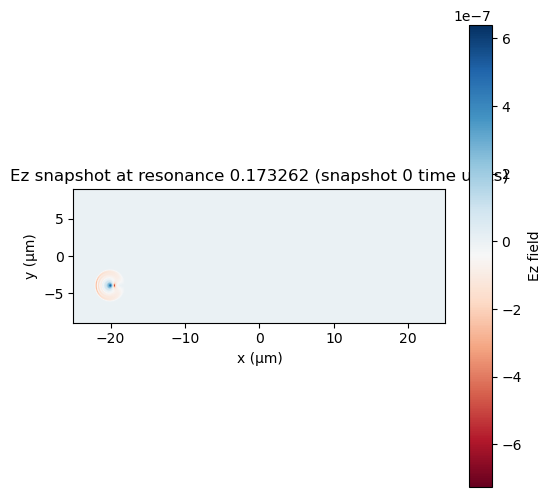

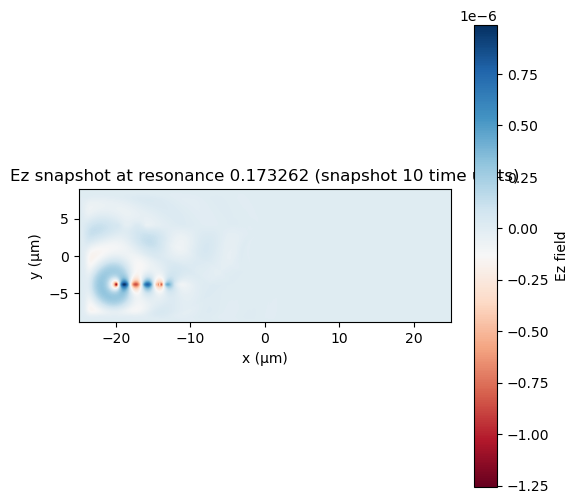

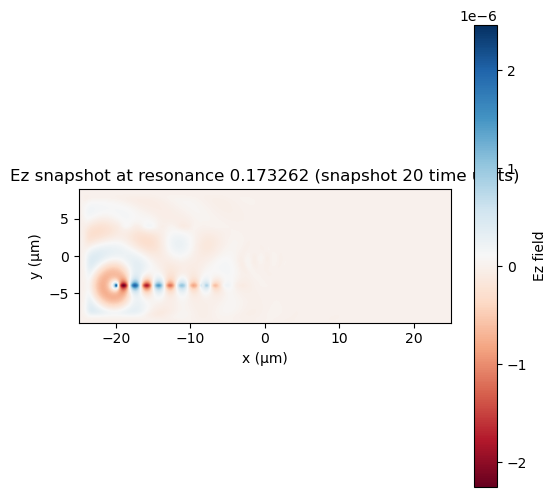

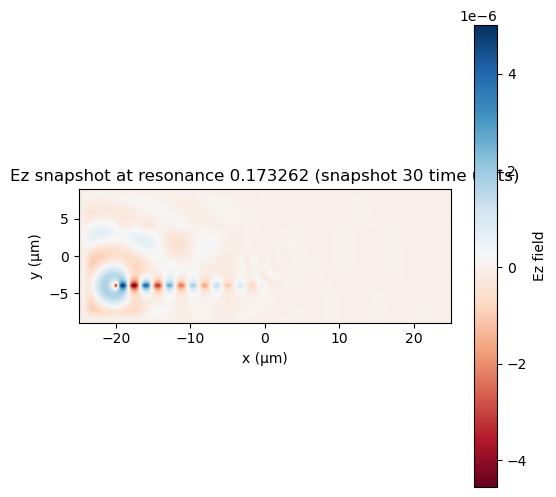

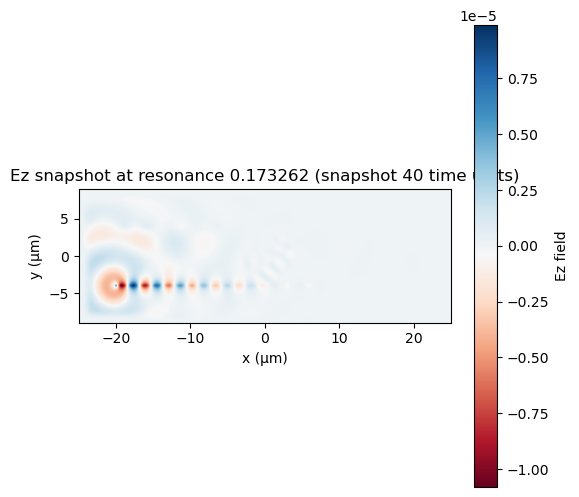

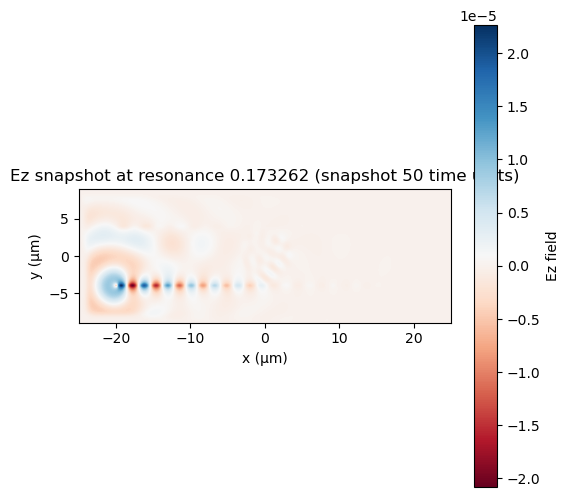

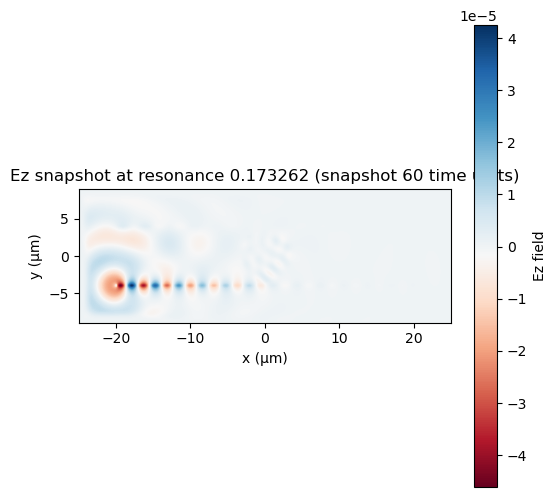

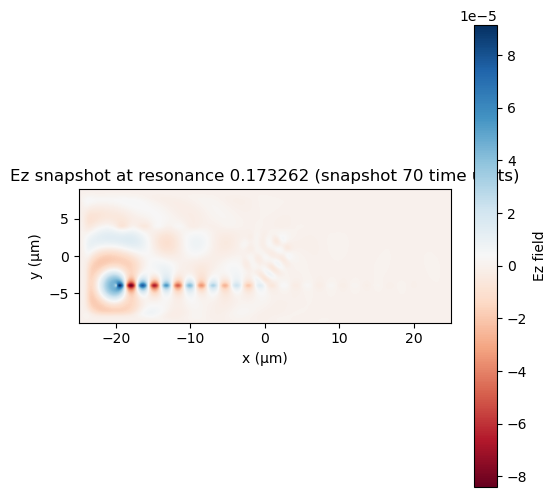

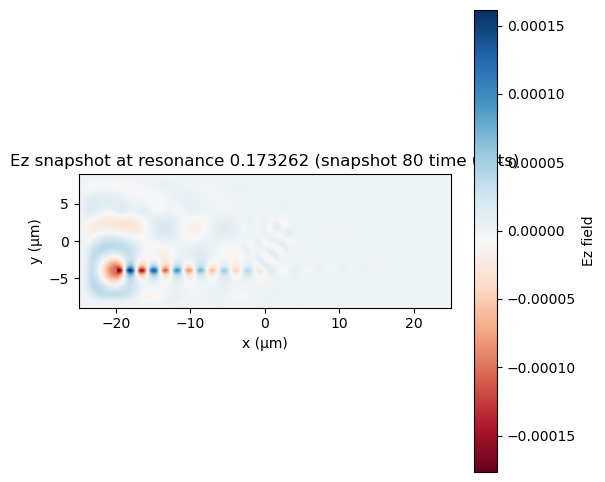

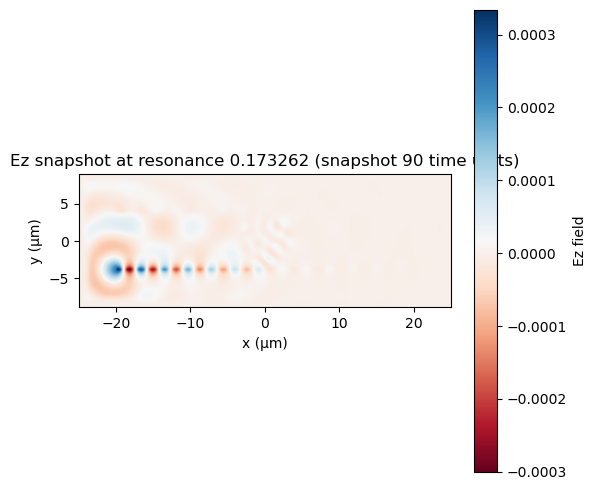

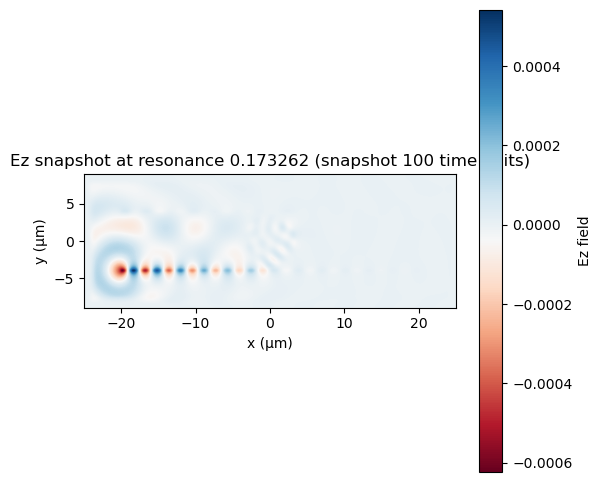

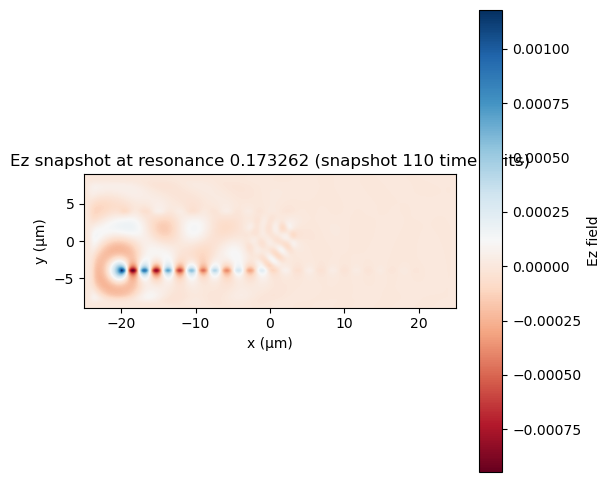

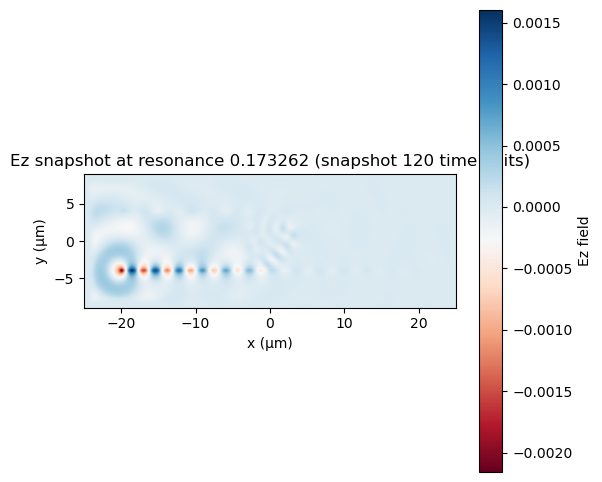

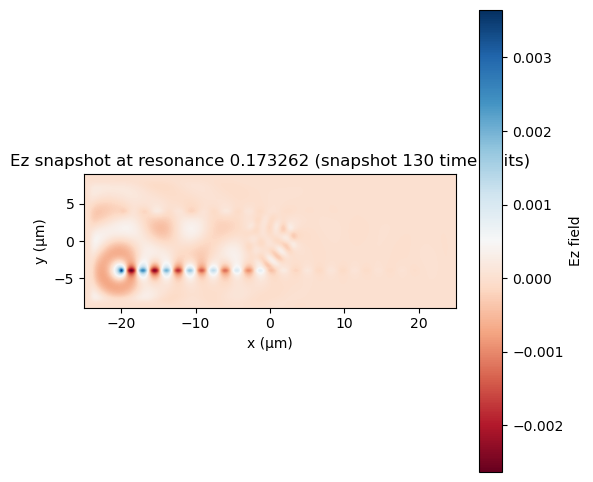

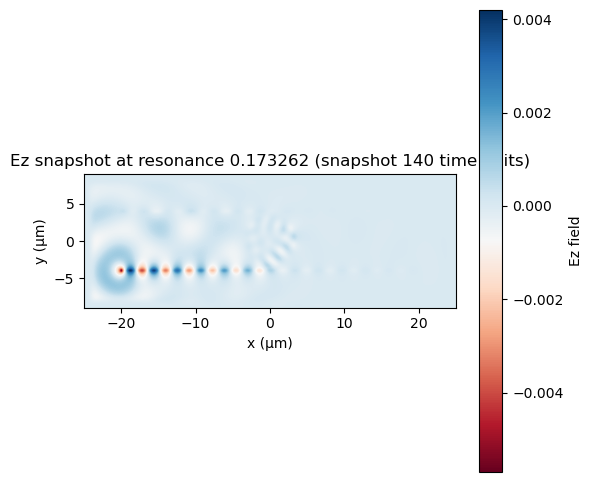

In [45]:
# -----------------------------
# 7) Run a new simulation at the resonance frequency
# -----------------------------
# Use a narrow Gaussian centered at the resonance frequency
fwidth_res = 0.05 * resonance_freq  # narrow enough to excite mostly the mode
sources_res = [mp.Source(mp.GaussianSource(frequency=resonance_freq, fwidth=fwidth_res),
                         component=mp.Ez,
                         center=mp.Vector3(source_x, source_y),
                         size=mp.Vector3(0, wg_width, 0))]

sim_res = mp.Simulation(cell_size=cell,
                        geometry=geometry,
                        sources=sources_res,
                        boundary_layers=pml_layers,
                        resolution=resolution,
                        dimensions=2)

# -----------------------------
# 8) Store Ez snapshots during this resonant run
# -----------------------------
ez_snapshots = []

def store_snapshot(sim):
    ez_snapshots.append(sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez))

# Run and store snapshots every 2 time units for visualization
sim_res.run(mp.at_every(2, store_snapshot), until=300)  # increase until field is established

# -----------------------------
# 9) Plot some snapshots of the resonant mode
# -----------------------------
for i, field in enumerate(ez_snapshots[::10]):  # plot every 5th snapshot
    plt.figure(figsize=(6,6))
    plt.imshow(np.rot90(field), cmap="RdBu", origin="lower",
               extent=[-cell.x/2, cell.x/2, -cell.y/2, cell.y/2])
    plt.colorbar(label="Ez field")
    plt.title(f"Ez snapshot at resonance {resonance_freq:.6f} (snapshot {i*5*2} time units)")
    plt.xlabel("x (µm)")
    plt.ylabel("y (µm)")
    plt.show()